1. Baseline, eyes open
2. Baseline, eyes closed
3. Task 1 (open and close left or right fist)
4. Task 2 (imagine opening and closing left or right fist)
5. Task 3 (open and close both fists or both feet)
6. Task 4 (imagine opening and closing both fists or both feet)
7. Task 1
8. Task 2
9. Task 3
10. Task 4
11. Task 1
12. Task 2
13. Task 3
14. Task 4

### 讀取

In [24]:
import numpy as np
from scipy.signal import welch

def extract_frequency_features(segment, fs=200, freq_bands=[(1,4), (4,8), (8,12), (12,30)]):
    # segment: shape (channels, segment_length)
    # fs: 取樣頻率 (需根據你的資料實際取樣率設定)
    # freq_bands: 要計算能量的頻帶列表
    # 回傳此 segment 的頻域特徵 (channels, len(freq_bands))

    # 使用 welch 計算每個 channel 的 PSD
    # nperseg可自行調整，通常為 segment_length，不過需注意奇偶
    f, psd = welch(segment, fs=fs, nperseg=segment.shape[1], axis=1)

    # psd shape: (channels, freq_bins)
    # 接著計算各頻帶功率
    freq_features = []
    for ch in range(psd.shape[0]):
        ch_psd = psd[ch]
        band_powers = []
        for (low_f, high_f) in freq_bands:
            # 找到對應的頻率區間索引
            idx = np.logical_and(f >= low_f, f <= high_f)
            # 計算該頻帶能量 (可用 sum 或平均)
            band_power = np.sum(ch_psd[idx])
            band_powers.append(band_power)
        freq_features.append(band_powers)
    freq_features = np.array(freq_features)  # (channels, len(freq_bands))
    freq_features = freq_features.flatten()  # 攤平

    return freq_features


In [25]:
def extract_fft_features(segment, fs=200, freq_bands=[(1,4), (4,8), (8,12), (12,30)]):
    # 將 time domain 信號對每個 channel 做 FFT
    fft_vals = np.fft.rfft(segment, axis=1)  # (channels, freq_bins)
    freqs = np.fft.rfftfreq(segment.shape[1], d=1/fs)
    
    # 計算能量譜
    psd = np.abs(fft_vals)**2
    
    freq_features = []
    for ch in range(psd.shape[0]):
        ch_psd = psd[ch]
        band_powers = []
        for (low_f, high_f) in freq_bands:
            idx = np.logical_and(freqs >= low_f, freqs <= high_f)
            band_power = np.sum(ch_psd[idx])
            band_powers.append(band_power)
        freq_features.append(band_powers)
    freq_features = np.array(freq_features).flatten()
    return freq_features


In [26]:
from scipy.stats import skew, kurtosis

def extract_time_features(segment):
    # segment: (channels, segment_length)
    # 計算各種時域特徵
    features = []
    for ch_data in segment:
        ch_mean = np.mean(ch_data)
        ch_std = np.std(ch_data)
        ch_var = np.var(ch_data)
        ch_min = np.min(ch_data)
        ch_max = np.max(ch_data)
        ch_skew = skew(ch_data)
        ch_kurt = kurtosis(ch_data)
        # 可加入更多特徵
        features.extend([ch_mean, ch_std, ch_var, ch_min, ch_max, ch_skew, ch_kurt])
    return np.array(features)


In [35]:
import os
import numpy as np
import pyedflib

# Subject
subject = 'S010'

# # 定義讀取的檔案列表和對應的標籤
read_list = ['R03', 'R04', 'R05', 'R06', 'R07', 'R08', 'R09', 'R10', 'R11', 'R12', 'R13', 'R14']
data_label = [1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4]

# ## 1 vs 4
# read_list = ['R03', 'R06', 'R07', 'R10', 'R11', 'R14']
# data_label = [1, 4, 1, 4, 1, 4]

# ## 2 vs 4
# read_list = ['R04', 'R06', 'R08', 'R10', 'R12', 'R14']
# data_label = [2, 4, 2, 4, 2, 4]

# 創建信號名稱到標籤的映射
signal_to_label = dict(zip(read_list, data_label))

# 初始化存放所有信號的字典
read_dict = {}

# 讀取所有 EDF 檔案並存入 read_dict
for i in read_list:
    # 打開 EDF 檔案
    file_path = '/Users/Jer_ry/Library/Mobile Documents/com~apple~CloudDocs/大四上/類神經網路/期末報告/physioNet/'+subject+'/' +subject+ i + '.edf'
    edf_reader = pyedflib.EdfReader(file_path)
    # 獲取信號數量
    n_signals = edf_reader.signals_in_file
    # 讀取所有信號數據
    signals = np.zeros((n_signals, edf_reader.getNSamples()[0]))
    for j in range(n_signals):
        signals[j, :] = edf_reader.readSignal(j)
    read_dict[i] = signals
    # 關閉 EDF 檔案
    edf_reader.close()
    # 打印信號數據和通道名稱
    print(f"Signals Shape for {i}: {signals.shape}")

# 設置分段參數
segment = 16  # 每個 segment 的長度
overlap = 0.5  # 重疊比例
step = int(segment * (1 - overlap))  # 計算步長

Signals Shape for R03: (64, 19680)
Signals Shape for R04: (64, 19680)
Signals Shape for R05: (64, 19680)
Signals Shape for R06: (64, 19680)
Signals Shape for R07: (64, 19680)
Signals Shape for R08: (64, 19680)
Signals Shape for R09: (64, 19680)
Signals Shape for R10: (64, 19680)
Signals Shape for R11: (64, 19680)
Signals Shape for R12: (64, 19680)
Signals Shape for R13: (64, 19680)
Signals Shape for R14: (64, 19680)


### Segmentaiion

In [36]:
all_data = []
all_labels = []

fs = 160  # 假設取樣率為 200 Hz (需確認你的 EDF 資料實際取樣率)

for key in read_list:
    print(f"Processing {key}...")
    signal = read_dict[key]  # (64, total_samples)
    channels, total_samples = signal.shape
    
    number_of_segments = int((total_samples - segment) / step) + 1
    signal_segments_features = []
    
    for i in range(number_of_segments):
        start = i * step
        end = start + segment
        if end > total_samples:
            break
        seg = signal[:, start:end]  # (64, segment_length)
        
        # 提取頻域特徵
        freq_features = extract_frequency_features(seg, fs=fs)  # or extract_fft_features(seg, fs=fs)
        
        # 提取時域特徵
        time_features = extract_time_features(seg)
        
        # 將頻域與時域特徵合併
        combined_features = np.concatenate([time_features, freq_features])
        
        signal_segments_features.append(combined_features)
    
    signal_segments_features = np.array(signal_segments_features)
    
    # 獲取對應的標籤
    label = signal_to_label[key]
    num_segments = signal_segments_features.shape[0]
    labels = np.full((num_segments,), label)
    
    all_data.append(signal_segments_features)
    all_labels.append(labels)

all_data = np.vstack(all_data)
all_labels = np.concatenate(all_labels)


Processing R03...
Processing R04...
Processing R05...
Processing R06...
Processing R07...
Processing R08...
Processing R09...
Processing R10...
Processing R11...
Processing R12...
Processing R13...
Processing R14...


2500 * 12 = 3000

In [37]:
# 使用 sklearn 的 train_test_split 一資料劃分
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    all_data, all_labels, test_size=0.2, random_state=42, stratify=all_labels
)
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (23606, 704)
X_test shape: (5902, 704)
y_train shape: (23606,)
y_test shape: (5902,)


In [38]:
# normalization
# before normalize reshape data back to raw data shape
X_train_2d = X_train.reshape([-1, 64])
X_test_2d = X_test.reshape([-1, 64])

# min-max normalization
from sklearn.preprocessing import MinMaxScaler
scaler3 = MinMaxScaler().fit(X_train)
X_train_norm1 = scaler3.transform(X_train)
X_test_norm1 = scaler3.transform(X_test)
print('After normalization, the shape of training feature:', X_train_norm1.shape,
      '\nAfter normalization, the shape of test feature:', X_test_norm1.shape)

After normalization, the shape of training feature: (23606, 704) 
After normalization, the shape of test feature: (5902, 704)


In [39]:
# # 將 noramalize 後的數據重新塑形為 3D，以便輸入到 AutoEncoder  中
# segment_length = segment
# no_feature = 64
# X_train_norm1 = X_train_norm1 .reshape([-1, segment_length, no_feature])
# X_test_norm1 = X_test_norm1.reshape([-1, segment_length, no_feature])
# y_train = y_train.reshape([-1, segment_length, 1])
# y_test = y_test.reshape([-1, segment_length, 1])
# print('After reshape, the shape of training feature:', X_train_norm1.shape,
#       '\nAfter reshape, the shape of test feature:', X_test_norm1.shape)

## 可視化原始資料：
* 圖示內容：展示了指定 EDF 文件中某一通道的完整信號數據。
* 目的：
  * 確認信號的整體形態（例如波形、振幅範圍、是否有明顯異常）。
  * 幫助理解信號是連續的時間序列數據。
* 應用場景：檢查讀取的數據是否正確無誤，以及探索每個通道是否有明顯的噪聲或失真。

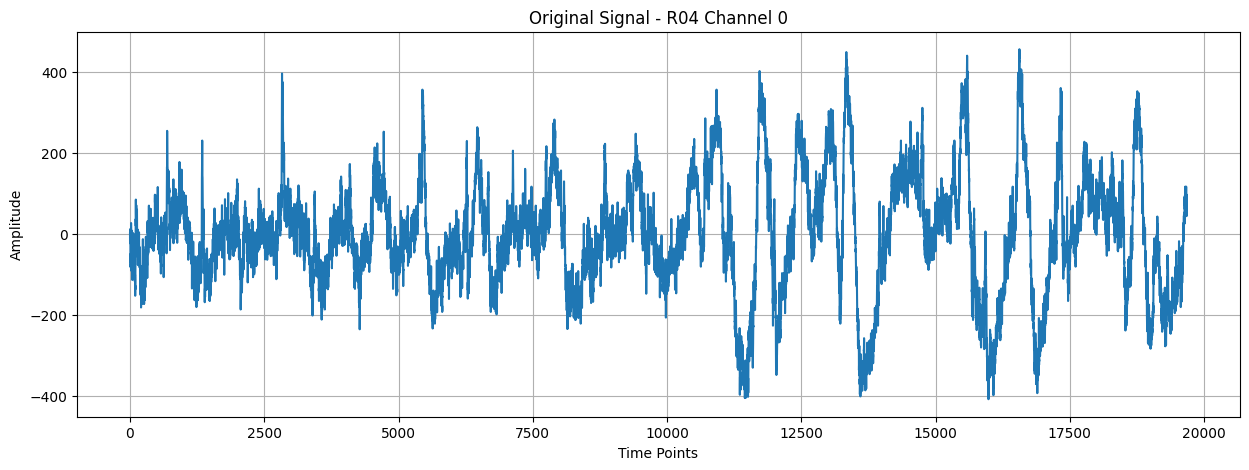

In [40]:
import matplotlib.pyplot as plt

# 可視化一個檔案中的第一個通道信號
file_key = 'R04'  # 指定檔案名稱
signal = read_dict[file_key]  # 取得信號數據
channel = 0  # 指定通道

plt.figure(figsize=(15, 5))
plt.plot(signal[channel, :])
plt.title(f"Original Signal - {file_key} Channel {channel}")
plt.xlabel("Time Points")
plt.ylabel("Amplitude")
plt.grid()
plt.show()


### 可視化分段訊號：
* 圖示內容：展示了分段後的信號數據，其中一段的某一通道信號。
* 目的：
  * 確保分段過程正確，信號段的長度符合設定的 segment 參數。
  * 檢查分段後的信號是否保留了有用的特徵（如明顯的振幅變化或周期性模式）。
* 解讀方式：
  * 分段完整性：確保每段信號都保留了足夠的特徵。例如，分段後的信號仍能清晰呈現周期性或尖峰特徵。
  * 邊界效應：檢查分段的頭尾部分是否出現明顯的邊界效應（如信號截斷），這可能影響後續分析。
  * 對比不同段：不同段之間是否有明顯差異，可能反映時間內的信號變化。
* 下一步：
  * 如果信號分段後特徵不明顯，考慮調整 segment 或 overlap 的參數。
* 應用場景：驗證信號分段過程是否有效，避免錯誤的截斷或丟失重要數據。

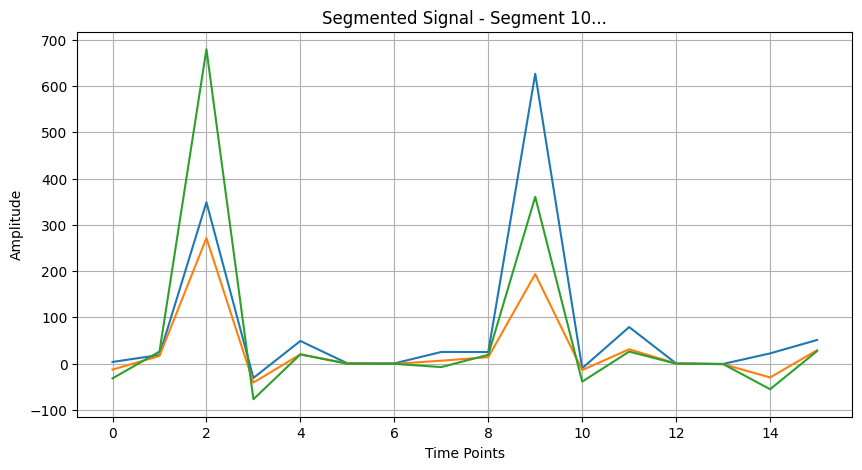

In [41]:
# 可視化分段信號
segment_id = 10  # 指定要檢視的 segment
signal_segment = all_data[segment_id].reshape(-1, segment)  # 還原為原始形狀
signal_segment_1 = all_data[segment_id+1].reshape(-1, segment)  # 還原為原始形狀
signal_segment_2 = all_data[segment_id+2].reshape(-1, segment)  # 還原為原始形狀

plt.figure(figsize=(10, 5))
plt.plot(signal_segment[0, :], label='Segment 1')  # 顯示第一個通道的片段
plt.plot(signal_segment_1[0, :], label='Segment 2')  # 顯示第一個通道的片段
plt.plot(signal_segment_2[0, :], label='Segment 3')  # 顯示第一個通道的片段
plt.title(f"Segmented Signal - Segment {segment_id}...")
plt.xlabel("Time Points")
plt.ylabel("Amplitude")
plt.grid()
plt.show()


### 訊號分佈直方圖
* 圖示內容：展示所有信號數據的值分佈情況，以直方圖形式顯示。
* 目的：
  * 檢查數據值範圍，是否存在異常的極值（例如高 noise）。
  * 了解訊號值是否呈常態分佈或其他特定模式。
* 解讀方式：
  * 集中程度：數據是否集中在特定區間？例如，腦波信號通常有較小的振幅範圍，過大的範圍可能提示噪聲。
  * 極值檢查：直方圖中是否有異常的極值（長尾分佈或孤立峰值），這些可能是伪影或測量誤差。
  * 分佈形態：是否接近正態分佈？大多數信號的分佈應該對稱或略有偏態。
* 下一步：
  * 如果數據分佈異常，需進一步濾波處理或截除極端值。
* 應用場景：在正規化或特徵提取之前檢查數據分佈是否需要特殊處理（例如去除極值或平滑）。

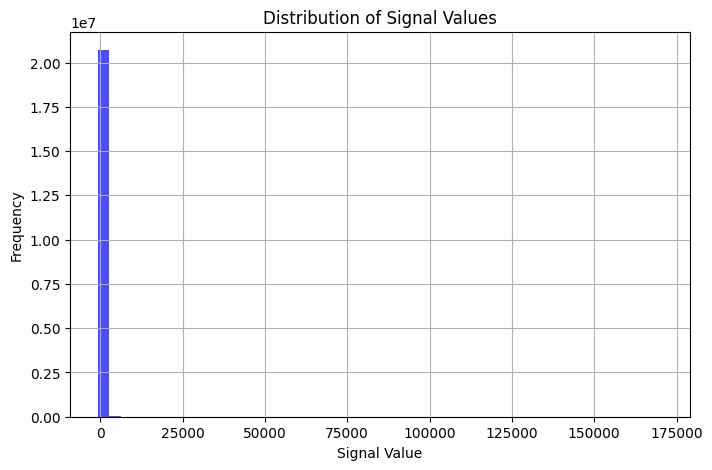

In [42]:
# 可視化信號值的分佈
plt.figure(figsize=(8, 5))
plt.hist(all_data.flatten(), bins=50, color='blue', alpha=0.7)
plt.title("Distribution of Signal Values")
plt.xlabel("Signal Value")
plt.ylabel("Frequency")
plt.grid()
plt.show()


### 可視化 label 分佈
- 圖示內容：展示數據標籤的分佈情況，檢查每個標籤的數據量。
- 目的：
  - 確保標籤分佈平衡，避免某些標籤的數據量過多或過少導致偏差。
  - 幫助理解數據集的整體結構。
- 應用場景：在模型訓練前確認類別不平衡問題，必要時進行數據重採樣。


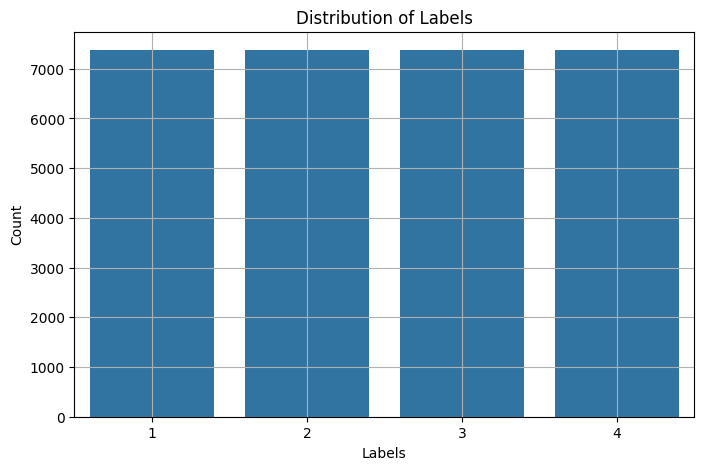

In [43]:
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.countplot(x=all_labels)
plt.title("Distribution of Labels")
plt.xlabel("Labels")
plt.ylabel("Count")
plt.grid()
plt.show()


### 比較 Normalized 後的訊號
* 圖示內容：對比原始信號與正規化後的信號數據。
* 目的：
  * 驗證正規化過程是否成功，數據值範圍是否被縮放到目標範圍（如 [0, 1]）。
  * 確保正規化不會改變信號的主要特徵（如振幅相對大小和波形）。
- 解讀方式：
  - 值範圍縮放：確認信號值是否成功縮放到 [0, 1] 或 [-1, 1] 範圍內。
  - 相對特徵保留：正規化後，信號的形態應該與原始信號一致。例如，波形的峰值和谷值應仍在同一位置。
  - 縮放異常：檢查是否有數據被壓縮過度或偏移（如所有值都接近 0）。
  - 下一步：
    - 如果正規化後信號的形態發生明顯改變，需檢查正規化方法或考慮其他預處理技術（如標準化）。
* 應用場景：檢查數據預處理的質量，避免因正規化失誤導致信息丟失。

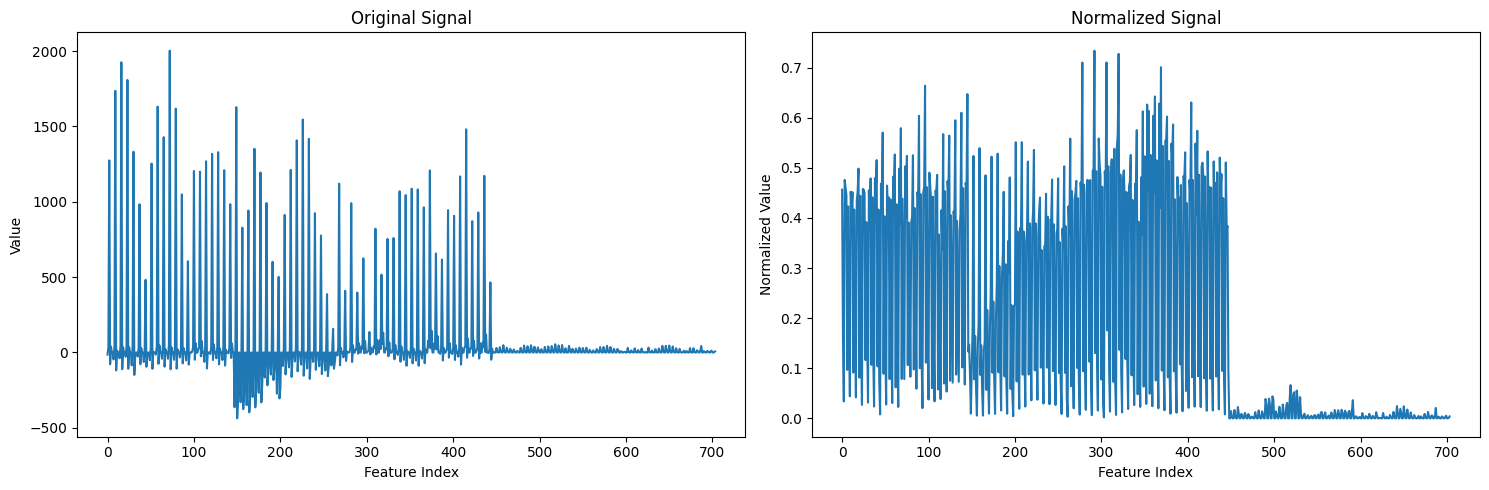

In [44]:
# 可視化正規化前後的信號
plt.figure(figsize=(15, 5))

# 原始信號
plt.subplot(1, 2, 1)
plt.plot(X_train[0])
plt.title("Original Signal")
plt.xlabel("Feature Index")
plt.ylabel("Value")

# 正規化信號
plt.subplot(1, 2, 2)
plt.plot(X_train_norm1[0])
plt.title("Normalized Signal")
plt.xlabel("Feature Index")
plt.ylabel("Normalized Value")

plt.tight_layout()
plt.show()


### 3D-data 的視覺化
* 圖示內容：展示自編碼器輸入的 3D 數據中，一個段的多通道信號數據。
* 目的：
  * 確認數據已按照分段和通道數正確塑形。
  * 可檢查多通道信號之間的同步性和一致性。
* 應用場景：在輸入深度學習模型（如自編碼器）之前檢查數據格式和結構是否正確。
* 解讀方式：
  * 通道間一致性：所有通道的信號模式應該有一定的關聯性，反映其來源（如腦波各通道之間的同步性）。
  * 段內特徵：每段信號應包含足夠的區別特徵，便於模型學習。
  * 異常波形：某些通道的信號如果呈現異常模式（如明顯高於或低於其他通道），可能需要進行通道去噪或調整。
  * 下一步：
    * 確認自編碼器輸入是否與設計目標一致，確保模型能有效學習多通道間的特徵。

In [45]:
# 可視化 3D 數據的某一段
segment_id = 8  # 指定段
data_3d = X_train_norm1[segment_id]

plt.figure(figsize=(10, 10))
for channel in range(data_3d.shape[1]):
    plt.plot(data_3d[:, channel], label=f"Channel {channel + 1}")

plt.title(f"3D Input Data - Segment {segment_id}")
plt.xlabel("Time Points")
plt.ylabel("Normalized Value")
# plt.legend(loc='upper right', ncol=2)
plt.show()


IndexError: tuple index out of range

<Figure size 1000x1000 with 0 Axes>

###  PCA 或 t-SNE 降維視覺化
#### PCA
* 圖示內容：使用 PCA 將高維數據降維到 2D，並根據標籤進行著色。
* 目的：
  * 查看不同類別的數據分佈情況，檢查是否存在明顯的分類邊界。
  * 確保數據中包含一定的區分性，支持後續分類任務。
* 應用場景：檢查特徵提取的效果，以及數據類別是否可分。
* 解讀方式：
  * 如果同一類別數據形成緊湊的簇，則說明數據具有良好的分類性。
  * 類別之間的分佈是否有明顯邊界，反映特徵提取的效果。
  * 如果類別分佈混亂，可能意味著需要更強的特徵工程。
#### t-SNE
* 圖示內容：使用 t-SNE 將高維數據降維到 2D，並根據標籤進行著色。
* 目的：
  * 更適合處理非線性數據的降維，視覺化數據的潛在結構。
  * 幫助理解不同類別之間的分佈關係。
* 應用場景：進一步檢查數據是否存在內在結構性差異，用於評估分類難度。
  * t-SNE 更適合非線性分佈，能夠更清晰地揭示內部結構。
  * 如果同類數據形成孤立的團簇，則模型可以輕鬆區分類別。
  * 如果不同類別之間的距離模糊或重疊，分類難度可能較高。
    * 根據降維視覺化結果調整特徵提取方法或增加更具鑑別力的特徵。

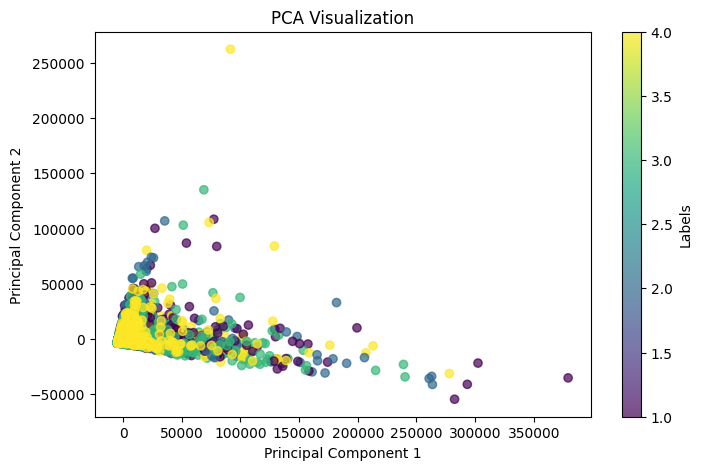

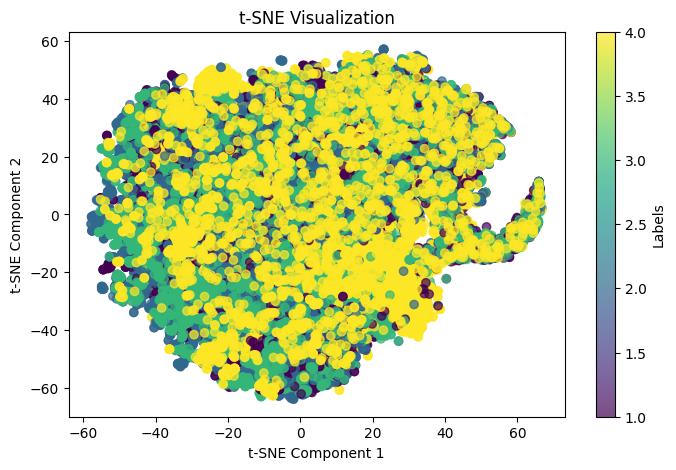

In [46]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# PCA 可視化
pca = PCA(n_components=2)
X_pca = pca.fit_transform(all_data)

plt.figure(figsize=(8, 5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=all_labels, cmap='viridis', alpha=0.7)
plt.title("PCA Visualization")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label="Labels")
plt.show()

# t-SNE 可視化
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
X_tsne = tsne.fit_transform(all_data)

plt.figure(figsize=(8, 5))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=all_labels, cmap='viridis', alpha=0.7)
plt.title("t-SNE Visualization")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.colorbar(label="Labels")
plt.show()


## AE + KNN (2 vs 4)

In [47]:
import torch
import torch.nn as nn
import torch.utils.data as Data
from sklearn.neighbors import KNeighborsClassifier


# 將數據轉換為 PyTorch 張量
X_train_norm1 = torch.tensor(X_train_norm1).float()
y_train = torch.tensor(y_train.flatten()).long()
X_test_norm1 = torch.tensor(X_test_norm1).float()
y_test = torch.tensor(y_test.flatten()).long()

# 超參數
LR = 0.005  # learning rate
EPOCH = 100
BATCH_size = 64

# 設置 data loader
train_data = Data.TensorDataset(X_train_norm1, y_train)
train_loader = Data.DataLoader(dataset=train_data, batch_size=BATCH_size, shuffle=True)

# 定義 AutoEncoder
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(all_data.shape[1], 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 4),
        )
        self.decoder = nn.Sequential(
            nn.Linear(4, 64),
            nn.ReLU(),
            nn.Linear(64, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, all_data.shape[1]),
            nn.Sigmoid(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

autoencoder = AutoEncoder()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=LR)
loss_func = nn.MSELoss()

# 訓練 AutoEncoder
knn = KNeighborsClassifier(n_neighbors=3)
best_acc = []

for epoch in range(EPOCH):
    autoencoder.train()
    for step, (b_x, b_y) in enumerate(train_loader):
        b_x_flat = b_x.view(b_x.size(0), -1)  # 展平输入
        encoded, decoded = autoencoder(b_x_flat)
        loss = loss_func(decoded, b_x_flat)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if step % 100 == 0:
            print('Epoch: ', epoch, '| Step:', step, '| train loss: %.4f' % loss.item())

    # 評估 AutoEncoder
    autoencoder.eval()
    with torch.no_grad():
        X_train_flat = X_train_norm1.view(X_train_norm1.size(0), -1)
        X_test_flat = X_test_norm1.view(X_test_norm1.size(0), -1)

        encoded_train, _ = autoencoder(X_train_flat)
        encoded_test, _ = autoencoder(X_test_flat)
        knn.fit(encoded_train.numpy(), y_train.numpy())
        acc = knn.score(encoded_test.numpy(), y_test.numpy())
        best_acc.append(acc)
        print('Epoch: ', epoch, '| Test Accuracy: %.4f' % acc)

print('Best Test Accuracy:', max(best_acc))


Epoch:  0 | Step: 0 | train loss: 0.1476
Epoch:  0 | Step: 100 | train loss: 0.0044
Epoch:  0 | Step: 200 | train loss: 0.0049
Epoch:  0 | Step: 300 | train loss: 0.0039
Epoch:  0 | Test Accuracy: 0.2562
Epoch:  1 | Step: 0 | train loss: 0.0042
Epoch:  1 | Step: 100 | train loss: 0.0033
Epoch:  1 | Step: 200 | train loss: 0.0031
Epoch:  1 | Step: 300 | train loss: 0.0033
Epoch:  1 | Test Accuracy: 0.2657
Epoch:  2 | Step: 0 | train loss: 0.0038
Epoch:  2 | Step: 100 | train loss: 0.0034
Epoch:  2 | Step: 200 | train loss: 0.0034
Epoch:  2 | Step: 300 | train loss: 0.0029
Epoch:  2 | Test Accuracy: 0.2960
Epoch:  3 | Step: 0 | train loss: 0.0033
Epoch:  3 | Step: 100 | train loss: 0.0032
Epoch:  3 | Step: 200 | train loss: 0.0031
Epoch:  3 | Step: 300 | train loss: 0.0031
Epoch:  3 | Test Accuracy: 0.3004
Epoch:  4 | Step: 0 | train loss: 0.0035
Epoch:  4 | Step: 100 | train loss: 0.0029
Epoch:  4 | Step: 200 | train loss: 0.0026
Epoch:  4 | Step: 300 | train loss: 0.0031
Epoch:  4 | Te

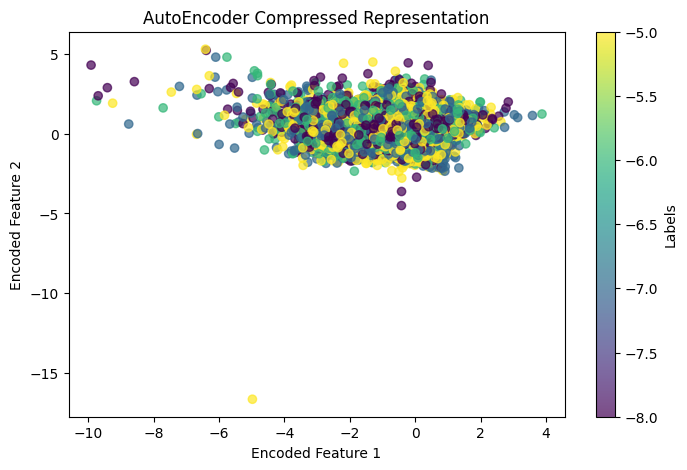

In [57]:
# 可視化 AutoEncoder 的壓縮表示
encoded_train = encoded_train.numpy()
encoded_test = encoded_test.numpy()

plt.figure(figsize=(8, 5))
plt.scatter(encoded_train[:, 0], encoded_train[:, 1], c=y_train, cmap='viridis', alpha=0.7)
plt.title("AutoEncoder Compressed Representation")
plt.xlabel("Encoded Feature 1")
plt.ylabel("Encoded Feature 2")
plt.colorbar(label="Labels")
plt.show()

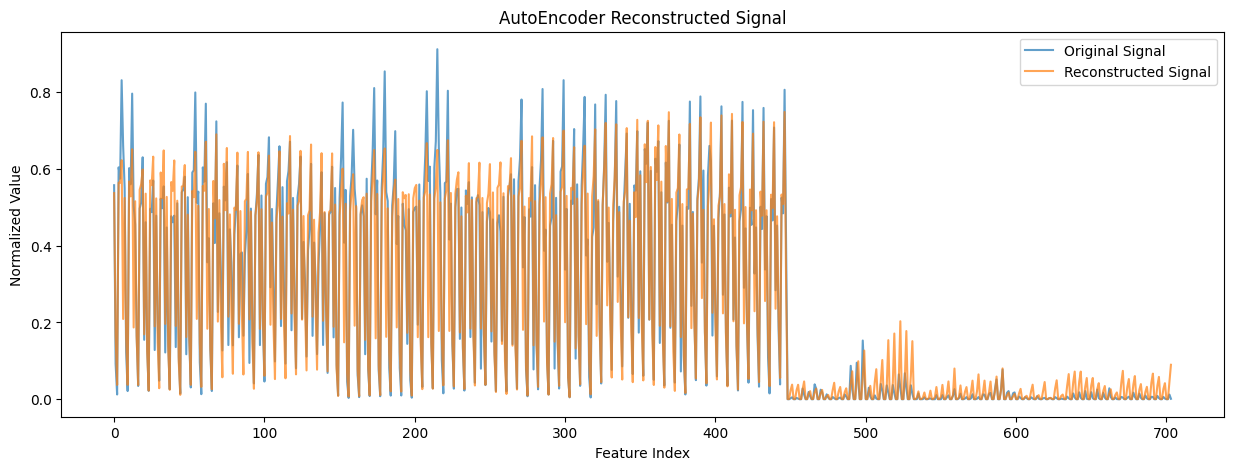

In [58]:
# 可視化 AutoEncoder 的重建效果
autoencoder.eval()
with torch.no_grad():
    _, decoded_data = autoencoder(X_test_flat)
    decoded_data = decoded_data.numpy()

plt.figure(figsize=(15, 5))
plt.plot(X_test_norm1[0], label='Original Signal', alpha=0.7)
plt.plot(decoded_data[0], label='Reconstructed Signal', alpha=0.7)
plt.title("AutoEncoder Reconstructed Signal")
plt.xlabel("Feature Index")
plt.ylabel("Normalized Value")
plt.legend()

In [56]:
import numpy as np
from sklearn.model_selection import train_test_split

# 假設此時你的 all_data, all_labels 已經定義完成
# all_data: shape (N, features)
# all_labels: shape (N, ), 標籤為整數類別(如 1,2,3,4)

# 先假設標籤從 1 開始，如果標籤不是從 0 開始，建議轉換一下
all_labels = all_labels - 1  # 若原標籤為1,2,3,4，轉成0,1,2,3

X_train, X_test, y_train, y_test = train_test_split(all_data, all_labels, test_size=0.2, random_state=42, stratify=all_labels)

class CPN:
    def __init__(self, input_dim, som_size=(10,10), num_classes=4, som_lr=0.1, som_epochs=2000):
        self.input_dim = input_dim
        self.som_size = som_size
        self.num_classes = num_classes
        self.som_lr = som_lr
        self.som_epochs = som_epochs
        
        # 初始化 SOM 權重，shape: (som_x, som_y, input_dim)
        self.som_weights = np.random.randn(som_size[0], som_size[1], input_dim)
        
        # 初始化 Grossberg layer 權重
        self.grossberg_weights = np.random.randn(som_size[0]*som_size[1], num_classes)
        
    def find_bmu(self, x):
        diff = self.som_weights - x
        dist = np.sum(diff**2, axis=2)
        bmu_idx = np.unravel_index(np.argmin(dist), self.som_size)
        return bmu_idx
    
    def train_som(self, X):
        # 簡易的 SOM 訓練，不包含鄰域函式
        for epoch in range(self.som_epochs):
            idx = np.random.randint(0, X.shape[0])
            x = X[idx]
            bmu_idx = self.find_bmu(x)
            # 更新 BMU 權重
            self.som_weights[bmu_idx] += self.som_lr * (x - self.som_weights[bmu_idx])
            
            # 可加入學習率衰減機制
            # if epoch % 500 == 0:
            #     self.som_lr *= 0.9
    
    def encode_input_with_som(self, X):
        # 將資料經 SOM 映射為 One-hot 編碼
        som_x, som_y = self.som_size
        encoded = []
        for x in X:
            bmu_idx = self.find_bmu(x)
            bmu_flat = bmu_idx[0]*som_y + bmu_idx[1]
            one_hot = np.zeros(som_x*som_y)
            one_hot[bmu_flat] = 1.0
            encoded.append(one_hot)
        return np.array(encoded)
    
    def train_grossberg(self, X_encoded, Y, lr=0.01, epochs=500):
        # 將 Y 轉成 one-hot
        Y_one_hot = np.zeros((Y.shape[0], self.num_classes))
        for i, label in enumerate(Y):
            Y_one_hot[i, label] = 1
        
        for ep in range(epochs):
            net = X_encoded.dot(self.grossberg_weights)
            diff = Y_one_hot - net
            grad = -X_encoded.T.dot(diff) / X_encoded.shape[0]
            self.grossberg_weights -= lr * grad
    
    def predict(self, X):
        encoded = self.encode_input_with_som(X)
        net = encoded.dot(self.grossberg_weights)
        preds = np.argmax(net, axis=1)
        return preds

# 建立 CPN 實例
input_dim = X_train.shape[1]  # Features數量
num_classes = len(np.unique(y_train)) # 類別數量
cpn = CPN(input_dim=input_dim, som_size=(3,3), num_classes=num_classes, som_lr=0.01, som_epochs=10000)

# 訓練 SOM (無監督)
print("Training SOM...")
cpn.train_som(X_train)

# 使用訓練好的 SOM 將訓練資料編碼
X_train_encoded = cpn.encode_input_with_som(X_train)

# 訓練 Grossberg layer (有監督)
print("Training Grossberg layer...")
cpn.train_grossberg(X_train_encoded, y_train, lr=0.01, epochs=5000)

# 測試集評估
y_pred = cpn.predict(X_test)
acc = np.mean(y_pred == y_test)
print("Test Accuracy:", acc)


Training SOM...
Training Grossberg layer...


IndexError: index -6 is out of bounds for axis 1 with size 4